# Diabetes prediction: random forest

## Notebook set-up

This notebook builds on the decision tree analysis by implementing **Random Forest** - an ensemble method that combines multiple decision trees for better performance. We import the same libraries as before, plus `RandomForestClassifier` and add a waiting mechanism to ensure the decision tree notebook has completed first.

In [1]:
# Python standard library imports
import os
import pickle
import time
from pathlib import Path

# PyPI imports - data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyPI imports - statistical and machine learning libraries
from scipy.stats import randint, uniform, loguniform
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Internal imports - project-specific modules
import configuration as config
import functions as funcs

# Wait for the decision tree notebook to finish execution
while True:
    if os.path.exists(config.DECISION_TREE_MODEL):
        break

    else:
        time.sleep(5)

## 1. Data loading

### 1.1. Load data from disk

Load the pre-processed data from the decision tree notebook:

Instead of repeating the data preprocessing steps, we load the already cleaned and split dataset from the decision tree notebook. This ensures consistency across all algorithm comparisons and saves computational time.

In [2]:
# Load the preprocessed dataset that was saved from the decision tree notebook
with open(config.DATA_FILE, 'rb') as input_file:
    dataset = pickle.load(input_file)

# Extract training and testing dataframes from the loaded dictionary
training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

A quick verification that we've loaded the correct preprocessed dataset with the expected features and format.

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
725,4,112,78,40,0,39.4,0.236,38,0
66,0,109,88,30,0,32.5,0.855,38,1
175,8,179,72,42,130,32.7,0.719,36,1
1,1,85,66,29,0,26.6,0.351,31,0
209,7,184,84,33,0,35.5,0.355,41,1


## 2. Model training

### 2.1. Previous scores

We begin the Random Forest modeling process by first loading previous model results, then training both a basic and optimized Random Forest. This ensemble method should outperform the single decision tree by reducing overfitting through averaging multiple trees.

In [4]:
# Load cross validation scores from previous models
with open(config.CROSS_VAL_SCORES_FILE, 'rb') as input_file:
    cross_val_scores = pickle.load(input_file)

We load the cross-validation scores from previous models (logistic regression, decision tree, optimized decision tree) to maintain a comprehensive comparison across all algorithms tested in this project.

### 2.2. Random forest model

Score a random forest model:

Random Forest is an ensemble method that builds multiple decision trees and averages their predictions. Key advantages:
- **Reduced overfitting**: Multiple trees reduce variance compared to a single tree
- **Better generalization**: Averaging helps smooth out individual tree quirks
- **Feature randomness**: Each tree uses a random subset of features, improving robustness
- **Parallel training**: Trees can be trained independently, making it scalable

We start with default hyperparameters using the same preprocessing pipeline.

In [5]:
# Load the list of features to impute
with open(config.IMPUTED_FEATURES_FILE, 'rb') as input_file:
    imputed_features = pickle.load(input_file)

# Create the imputer
knn_imputer = ColumnTransformer([('imputer', KNNImputer(), imputed_features)], remainder='passthrough')

# Create a random forest classifier with default hyperparameters
tree_model = RandomForestClassifier(
    class_weight=config.CLASS_WEIGHT,  # Handle class imbalance
    random_state=config.RANDOM_SEED    # Ensure reproducible results
)

naive_model = Pipeline(
    steps=[
        ('KNN', knn_imputer),
        ('classifier', tree_model)
    ]
)

# Train the naive random forest model
naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Calculate and display training accuracy
accuracy = accuracy_score(naive_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of random forest: {accuracy:.1f}%')

Training accuracy of random forest: 100.0%


Cross-validation provides an unbiased estimate of Random Forest performance. We expect this ensemble method to show:
- **Lower variance**: More consistent performance across different data subsets
- **Better average performance**: Typically outperforms single decision trees
- **Reduced overfitting**: Less prone to memorizing training data quirks

In [6]:
# Perform cross-validation on the naive random forest model
scores = cross_val_score(
    naive_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with previous models and future optimized model
cross_val_scores['Model'].extend(['Random forest']*len(scores))
cross_val_scores['Score'].extend(scores * 100)

# Display cross-validation results with mean and standard deviation
print(f'Cross-validation accuracy of random forest: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy of random forest: 75.0 +/- 6.2%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter search

Random Forest hyperparameter optimization focuses on both individual tree parameters and ensemble-specific settings:

**Ensemble parameters**: 
- `n_estimators`: Number of trees in the forest (more trees = better performance but slower training)

**Individual tree parameters**: Same as decision trees (depth, splits, leaf constraints)

**Feature sampling**: Controls how features are randomly selected for each tree

Optimization should improve upon the baseline Random Forest performance.

In [7]:
%%time

# Define hyperparameter search space for random forest optimization
hyperparameters = {
    'KNN__imputer__n_neighbors': randint(1, 3),
    'KNN__imputer__weights': ['uniform', 'distance'],
    'KNN__imputer__add_indicator': [True, False],
    'classifier__n_estimators': randint(2, 200),
    'classifier__criterion':['gini','entropy','log_loss'],
    'classifier__max_depth':randint(1, 20),
    'classifier__min_samples_split':randint(2, 40),
    'classifier__min_samples_leaf':randint(1, 20),
    'classifier__min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'classifier__max_features':uniform(loc=0.1, scale=0.9),
    'classifier__max_leaf_nodes':randint(2, 100),
    'classifier__min_impurity_decrease':loguniform(10**-5, 1.0),
    'classifier__ccp_alpha':loguniform(10**-5, 10.0)
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    naive_model,
    hyperparameters,
    return_train_score=True,                 # Return training scores for analysis
    cv=config.CROSS_VAL_FOLDS,               # Number of cross-validation folds
    n_jobs=-1,                               # Use all available CPU cores
    n_iter=config.RANDOM_SEARCH_ITERATIONS,  # Number of parameter combinations to try
    random_state=config.RANDOM_SEED          # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in winning_hyperparameters.items():
    print(f' {key}: {value}')

print()

print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters:

 KNN__imputer__add_indicator: True
 KNN__imputer__n_neighbors: 1
 KNN__imputer__weights: uniform
 classifier__ccp_alpha: 3.2529183381311655e-05
 classifier__criterion: log_loss
 classifier__max_depth: 7
 classifier__max_features: 0.4227071951504747
 classifier__max_leaf_nodes: 95
 classifier__min_impurity_decrease: 0.004087586383858148
 classifier__min_samples_leaf: 15
 classifier__min_samples_split: 2
 classifier__min_weight_fraction_leaf: 7.297739101266425e-05
 classifier__n_estimators: 83

Run time (20 CPUs):

CPU times: user 4h 38min 2s, sys: 4min 33s, total: 4h 42min 36s
Wall time: 4h 45min 33s


### 3.2. Hyperparameter optimization results

Visualizing the hyperparameter optimization results helps us understand:
- **Training vs validation gap**: Random Forests typically have smaller gaps than single trees
- **Parameter sensitivity**: Which hyperparameters most impact performance
- **Optimization success**: Whether we found parameter combinations that improve over defaults

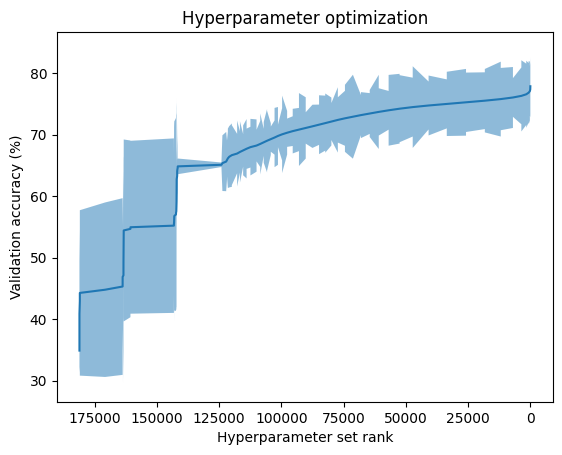

In [8]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

We evaluate the optimized Random Forest using the same cross-validation approach to fairly compare with all previous models. This will reveal the performance gain from hyperparameter tuning on the ensemble method.

In [9]:
# Perform cross-validation on the optimized random forest model
scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with all other models
cross_val_scores['Model'].extend(['Optimized random forest']*len(scores))
cross_val_scores['Score'].extend(scores * 100)

# Display cross-validation results for the optimized random forest
print(f'Optimized random forest cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Optimized random forest cross-validation accuracy: 77.9 +/- 4.7%


## 4. Evaluation

### 4.1. Cross-validation performance

Now we compare Random Forest performance against all previous models to understand:
- **Ensemble advantage**: How much improvement Random Forest provides over single trees
- **Model ranking**: Where Random Forest stands in our algorithm comparison
- **Consistency**: Whether Random Forest shows more stable performance

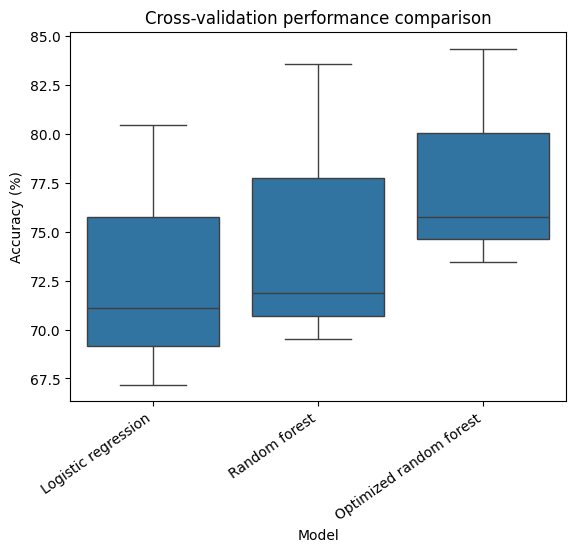

In [10]:
# Create boxplot to compare cross-validation performance
models = ['Logistic regression', 'Random forest', 'Optimized random forest']
plot_scores = pd.DataFrame.from_dict(cross_val_scores)
plot_scores = plot_scores[plot_scores['Model'].isin(models)]

sns.boxplot(plot_scores, x='Model', y='Score')
plt.title('Cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=35, ha='right')  # Rotate x-axis labels for better readability
plt.show()

A focused comparison of the most relevant models: logistic regression baseline, basic Random Forest, and optimized Random Forest. This shows the progression from linear model to ensemble method and the benefit of hyperparameter tuning.

### 4.2. Test set performance

Final evaluation on the held-out test set reveals true model performance on completely unseen data. The confusion matrices will show:
- **Ensemble stability**: Whether Random Forest predictions are more reliable
- **Class balance**: How well each model handles both diabetic and non-diabetic cases
- **Real-world performance**: The ultimate test of model effectiveness

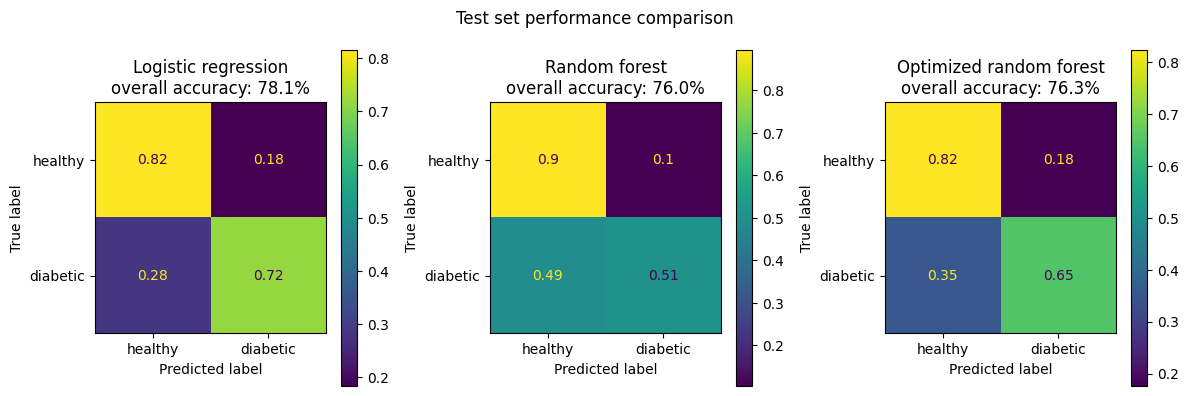

In [11]:
# Retrain both naive and optimized random forest models on the full training set
result = naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
result = best_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Load the logistic regression model for comparison
with open(config.LOGISTIC_REGRESSION_MODEL, 'rb') as input_file:
    linear_model = pickle.load(input_file)

# Generate confusion matrices for both random forest models on the test set
funcs.plot_confusion_matrices(
    models = {
        'Logistic regression': linear_model,
        'Random forest': naive_model,
        'Optimized random forest': best_model
    },
    testing_df=testing_df
)

## 5. Save

### 5.1. Cross-validation scores

We save the Random Forest results to build our comprehensive model comparison database for the final project evaluation and to preserve the trained models for potential deployment.

In [12]:
with open(config.CROSS_VAL_SCORES_FILE, 'wb') as output_file:
    pickle.dump(cross_val_scores, output_file)

Update our cross-validation scores database with Random Forest results for use in subsequent notebooks (gradient boosting) and final model comparison.

### 5.2. Model

Save the optimized Random Forest model and its hyperparameters for:
- **Deployment**: The model can be loaded and used for predictions
- **Reproducibility**: Exact hyperparameters can be recreated
- **Comparison**: Other notebooks can load and compare against this model

In [13]:
# Save the optimal hyperparameters for future use or reproduction
with open(config.RANDOM_FOREST_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(winning_hyperparameters, output_file)

# Save the trained best random forest model for deployment or further analysis
with open(config.RANDOM_FOREST_MODEL, 'wb') as output_file:
    pickle.dump(best_model, output_file)